# Development of a wind force model
So far the vessel manoeuvring models (VMM:s) have only considered the hydrodynamic forces. This notebook explores how the wind force can be incorporated into the models in a convenient way.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import smallest_signed_angle

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [51]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.test_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
wind_data = catalog.load(f"{ship}.wind_data")
model_loaders = catalog.load(f"{ship}.models")

[05/17/23 10:51:21] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=401074;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=281391;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/17/23 10:51:21] INFO     Kedro project phd                                                      ]8;id=89692;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=938981;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=641764;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=491451;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=128740;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=384658;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=73289;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=904988;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=895198;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=122443;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=438986;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=500543;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.wind_data' (CSVDataSet)...                   ]8;id=6561;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=716724;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=713646;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=27985;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [5]:
wind_data_HMD = pd.read_csv("HMD_PCTC.wind_data.csv", index_col=0)
wind_data_HMD.rename(columns={column:column.lower().replace(' ','') for column in wind_data_HMD.columns}, inplace=True)

In [6]:
wind_data_HMD.head()

,cx,cy,ck,cn
awa [deg],,,,
0,-0.596,0.002,0.007,-0.001
10,-0.618,0.172,0.205,0.024
20,-0.623,0.400,0.464,0.048
30,-0.546,0.669,0.770,0.064
40,-0.328,0.900,1.014,0.077


In [7]:
wind_data_HMD.columns

Index(['cx', 'cy', 'ck', 'cn'], dtype='object')

In [8]:
wind_data

,Lpp [m],Sx [m2],Sy [m2],TWS [m/s],Vs [kts],AWS [m/s],Fx [N],Fy [N],Mx [Nm],Mz [Nm],Ml [Nm],Mn [Nm]
AWA [°],,,,,,,,,,,,
0,206,1008.34776,5433.5156,10,10,15.144000,-23669,395,-8761,13048,-5403.5,-28427
35,206,1008.34776,5433.5156,10,10,13.768543,-15176,275370,-6849529,42161608,-4508884.0,13247758
60,206,1008.34776,5433.5156,10,10,11.524900,9260,277602,-7386496,36149065,-5026879.0,7000855
90,206,1008.34776,5433.5156,10,10,8.575500,-11126,132302,-4020585,13323275,-2896018.0,-568435
120,206,1008.34776,5433.5156,10,10,6.380900,1644,77922,-2554601,4510682,-1892264.0,-3671128
145,206,1008.34776,5433.5156,10,10,5.341107,25,6645,-547,138922,55935.5,-558803
180,206,1008.34776,5433.5156,10,10,4.856000,7221,555,-11437,80869,-6719.5,22594


In [42]:
wind_data.iloc[0]['Sx [m2]']/(ship_data['scale_factor']**2)

1.1203864

In [43]:
wind_data.iloc[0]['Sy [m2]']/(ship_data['scale_factor']**2)

6.037239555555555

In [9]:
rho_air = 1.225
lpp = wind_data['Lpp [m]']
sx = wind_data['Sx [m2]']
sy = wind_data['Sy [m2]']
aws = wind_data['AWS [m/s]']
fx = wind_data['Fx [N]']
fy = wind_data['Fy [N]']
mz = wind_data['Mn [Nm]']

In [10]:
wind_data['awa'] = np.deg2rad(wind_data.index)
wind_data_HMD['awa'] = np.deg2rad(wind_data_HMD.index)

wind_data['awa'] = np.mod(wind_data['awa'] + np.pi, 2 * np.pi) - np.pi
wind_data_HMD['awa'] = np.mod(wind_data_HMD['awa'] + np.pi, 2 * np.pi) - np.pi
wind_data.sort_values(by='awa', inplace=True)
wind_data_HMD.sort_values(by='awa', inplace=True)


In [11]:
wind_data['cx'] = fx/(1/2*rho_air*sx*aws**2)
wind_data['cy'] = fy/(1/2*rho_air*sy*aws**2)
wind_data['cn'] = mz/(1/2*rho_air*sy*aws**2*lpp)

In [12]:
data = wind_data_HMD.copy()

x = data['awa'].abs()
y = data['cx']
coeffs_cx = np.polyfit(x=x, y=y, deg=6)


x = data['awa'].abs()
y = data['cy'].abs()
coeffs_cy = np.polyfit(x=x, y=y, deg=3)

x = data['awa'].abs()
y = data['cn']
mask = data['awa'] < 0
y.loc[mask]*=-1
coeffs_cn = np.polyfit(x=x, y=y, deg=3)

In [13]:
coeffs_cx

array([  0.17026096,  -1.83918845,   7.3656144 , -13.39004246,
        10.81894988,  -2.74459708,  -0.53037727])

In [14]:
def get_X(x, deg=1, const=True):
    
    if const:
        stop = -1
    else:
        stop = 0
        
    X = np.array(np.matrix([x**i for i in range(deg,stop,-1)]))
    return X

def get_X_abs(x, deg=1, const=True):
    
    if const:
        stop = -1
    else:
        stop = 0
        
    X = np.array(np.matrix([np.abs(x**i) for i in range(deg,stop,-1)]))
    return X

def get_X_sign(x, deg=1, const=True):
    
    if const:
        stop = -1
    else:
        stop = 0

    parts = [np.sign(x)*np.abs(x**i) for i in range(deg,stop,-1)]
        
    X = np.array(np.matrix(parts))
    return X
    

Text(0, 0.5, 'cn')

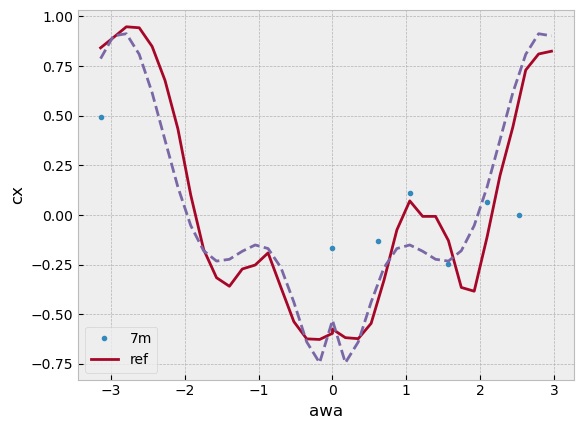

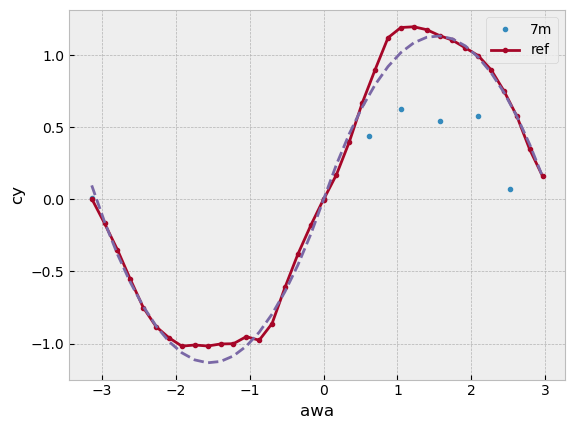

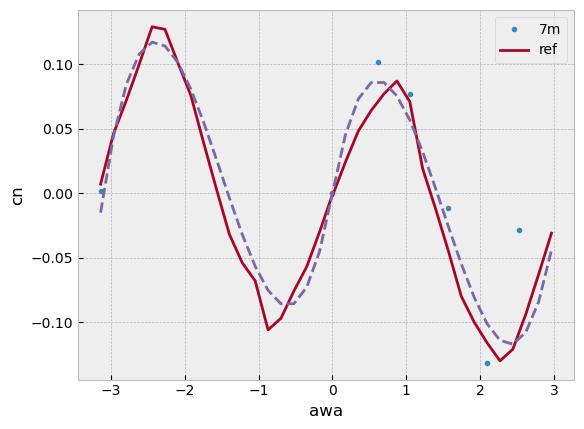

In [15]:
fig,ax=plt.subplots()
wind_data.plot(x='awa', y='cx', label='7m', style='.', ax=ax)
wind_data_HMD.plot(x='awa', y='cx', label='ref', ax=ax)

x = data['awa'].values
y = data['cx']
deg_x = 6
X = get_X_abs(x=x, deg=deg_x)
coeffs_cx,_,_,_ = np.linalg.lstsq(X.transpose(),y)
ax.plot(data['awa'],coeffs_cx.dot(X).flatten(),'--', label='polynom')
ax.set_ylabel('cx')

fig,ax=plt.subplots()
wind_data.plot(x='awa', y='cy', label='7m', style='.', ax=ax)
wind_data_HMD.plot(x='awa', y='cy', style='.-',label='ref', ax=ax)
y = data['cy']
deg_y = 2
X = get_X_sign(x=x, deg=deg_y, const=False)
coeffs_cy,_,_,_ = np.linalg.lstsq(X.transpose(),y)
ax.plot(data['awa'],coeffs_cy.dot(X).flatten(),'--', label='polynom')
ax.set_ylabel('cy')

fig,ax=plt.subplots()
wind_data.plot(x='awa', y='cn', label='7m', style='.', ax=ax)
wind_data_HMD.plot(x='awa', y='cn', label='ref', ax=ax)
y = data['cn'].copy()
mask = data['awa'] < 0
y.loc[mask]*=-1
deg_n = 3
X = get_X_sign(x=x, deg=deg_n, const=False)
coeffs_cn,_,_,_ = np.linalg.lstsq(X.transpose(),y)
ax.plot(data['awa'],coeffs_cn.dot(X).flatten(),'--', label='polynom')
ax.set_ylabel('cn')

In [16]:
def eq_abs(deg=1, symbol_prefix="C_x", const=True):
    
    if const:
        stop = -1
    else:
        stop = 0
    
    coefficient_symbols = get_coefficient_symbols(deg=deg, symbol_prefix=symbol_prefix, const=const)
    
    awa = sp.symbols('awa', real=True)
    return reduce(add,[sp.symbols(f"{symbol}")*sp.Abs(awa**i) for i,symbol in zip(range(deg,stop,-1), coefficient_symbols)])

def eq_sign(deg=1, symbol_prefix="C_x", const=True):
    
    if const:
        stop = -1
    else:
        stop = 0
        
    awa = sp.symbols('awa', real=True)
    
    coefficient_symbols = get_coefficient_symbols(deg=deg, symbol_prefix=symbol_prefix, const=const)
        
    return reduce(add,[sp.symbols(f"{symbol}")*awa*sp.Abs(awa**(i-1)) if np.mod(i,2)==0 else sp.symbols(f"{symbol}")*awa**i for i,symbol in zip(range(deg,stop,-1), coefficient_symbols)])


def get_coefficient_symbols(deg=1, symbol_prefix="C_x", const=True):
    
    if const:
        stop = -1
    else:
        stop = 0
        
    return [sp.symbols(f"{symbol_prefix}{i}") for i in range(deg,stop,-1)]
    


In [17]:
eq_abs(deg=deg_x)

C_x0 + C_x1*Abs(awa) + C_x2*awa**2 + C_x3*awa**2*Abs(awa) + C_x4*awa**4 + C_x5*awa**4*Abs(awa) + C_x6*awa**6

In [18]:
expression = eq_sign(deg=deg_y, const=False)
expression

C_x1*awa + C_x2*awa*Abs(awa)

In [19]:
awa = sp.symbols('awa', real=True)
expression.diff(awa)

C_x1 + C_x2*awa*sign(awa) + C_x2*Abs(awa)

In [20]:
aws, A_XV, A_YV, rho_A, F_Wx, F_Wy, M_Wz = sp.symbols('aws, A_XV, A_YV, rho_A, F_Wx, F_Wy, M_Wz', real=True)

C_xs = eq_abs(deg=deg_x, symbol_prefix='C_x')
#eq_F_Wx = sp.Eq(F_Wx, sp.Rational(1,2)*rho_A*A_XV*aws**2*C_xs)
eq_F_Wx = sp.expand(sp.Eq(F_Wx, rho_A*A_XV*aws**2*C_xs))  # 1/2 is stored in the C_x...

C_ys = eq_sign(deg=deg_y, symbol_prefix='C_y', const=False)
eq_F_Wy = sp.expand(sp.Eq(F_Wy, rho_A*A_YV*aws**2*C_ys))

C_ns = eq_sign(deg=deg_n, symbol_prefix='C_n', const=False)
eq_M_Wz = sp.expand(sp.Eq(M_Wz, rho_A*A_YV*aws**2*C_ns*L))


display(eq_F_Wx)
display(eq_F_Wy)
display(eq_M_Wz)


Eq(F_Wx, A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa) + A_XV*C_x6*awa**6*aws**2*rho_A)

Eq(F_Wy, A_YV*C_y1*awa*aws**2*rho_A + A_YV*C_y2*awa*aws**2*rho_A*Abs(awa))

Eq(M_Wz, A_YV*C_n1*L*awa*aws**2*rho_A + A_YV*C_n2*L*awa*aws**2*rho_A*Abs(awa) + A_YV*C_n3*L*awa**3*aws**2*rho_A)

In [21]:
coeffs_cx_dict = {str(symbol):value/2 for symbol,value in zip(get_coefficient_symbols(deg=deg_x, symbol_prefix="C_x", const=True), coeffs_cx)}
coeffs_cy_dict = {str(symbol):value/2 for symbol,value in zip(get_coefficient_symbols(deg=deg_y, symbol_prefix="C_y", const=False), coeffs_cy)}
coeffs_cn_dict = {str(symbol):value/2 for symbol,value in zip(get_coefficient_symbols(deg=deg_n, symbol_prefix="C_n", const=False), coeffs_cn)}

In [22]:
lambda_F_Wx = lambdify(eq_F_Wx.rhs)
lambda_F_Wy = lambdify(eq_F_Wy.rhs)
lambda_M_Wz = lambdify(eq_M_Wz.rhs)

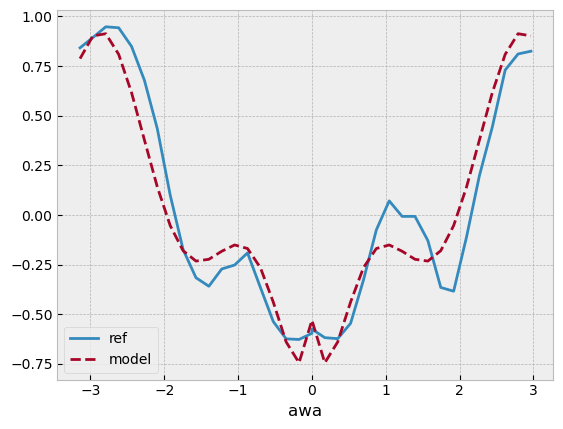

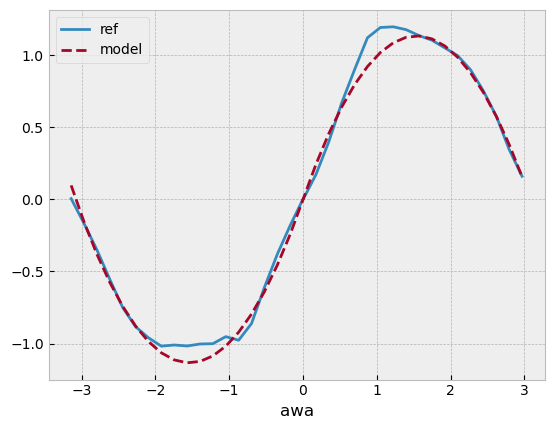

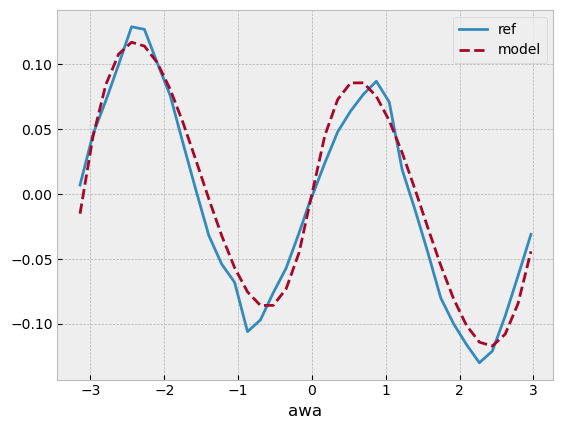

In [23]:
fig,ax=plt.subplots()
wind_data_HMD.plot(x='awa', y='cx', label='ref', ax=ax)
x = wind_data_HMD['awa']
y = 2*run(lambda_F_Wx, inputs=wind_data_HMD, **coeffs_cx_dict, aws=1, rho_A=1, A_XV=1)
ax.plot(x,y,'--', label='model')
ax.legend()


fig,ax=plt.subplots()
wind_data_HMD.plot(x='awa', y='cy', label='ref', ax=ax)
x = wind_data_HMD['awa']
y = 2*run(lambda_F_Wy, inputs=wind_data_HMD, **coeffs_cy_dict, aws=1, rho_A=1, A_YV=1)
ax.plot(x,y,'--', label='model')
ax.legend()

fig,ax=plt.subplots()
wind_data_HMD.plot(x='awa', y='cn', label='ref', ax=ax)
x = wind_data_HMD['awa']
y = 2*run(lambda_M_Wz, inputs=wind_data_HMD, **coeffs_cn_dict, aws=1, rho_A=1, A_YV=1, L=1)
ax.plot(x,y,'--', label='model')
ax.legend()


In [24]:
df_prime.loc['denominator','force']

L**2*U**2*rho/2

In [25]:
vmm.Y_eq

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v} + Y_{deltadeltadelta}*delta**3 + Y_{delta}*delta + Y_{rdeltadelta}*delta**2*r + Y_{rrdelta}*delta*r**2 + Y_{rrr}*r**3 + Y_{r}*r + Y_{udelta}*delta*u + Y_{ur}*r*u + Y_{uudelta}*delta*u**2 + Y_{uur}*r*u**2 + Y_{uuv}*u**2*v + Y_{uv}*u*v + Y_{vdeltadelta}*delta**2*v + Y_{vrdelta}*delta*r*v + Y_{vrr}*r**2*v + Y_{vvdelta}*delta*v**2 + Y_{vvr}*r*v**2 + Y_{vvv}*v**3 + Y_{v}*v)

In [26]:
sp.sign(-10)

-1

In [27]:
X_eq = sp.Eq(vmm.X_eq.lhs, vmm.X_eq.rhs + eq_F_Wx.rhs)
Y_eq = sp.Eq(vmm.Y_eq.lhs, vmm.Y_eq.rhs + eq_F_Wy.rhs)
N_eq = sp.Eq(vmm.N_eq.lhs, vmm.N_eq.rhs + eq_M_Wz.rhs)


In [28]:
X_eq

Eq(m*(\dot{u} - r**2*x_G - r*v), A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa) + A_XV*C_x6*awa**6*aws**2*rho_A + X_{\dot{u}}*\dot{u} + X_{deltadelta}*delta**2 + X_{rdelta}*delta*r + X_{rr}*r**2 + X_{udeltadelta}*delta**2*u + X_{urdelta}*delta*r*u + X_{urr}*r**2*u + X_{uu}*u**2 + X_{uvdelta}*delta*u*v + X_{uvr}*r*u*v + X_{u}*u + X_{vdelta}*delta*v + X_{vr}*r*v + X_{vv}*v**2)

In [29]:
vmm2 = VMM(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq)

In [30]:
model = model_loaders["vmm_abkowitz_diminished"]()

In [32]:
simulator = Simulator(X_eq=vmm2.X_eq, Y_eq=vmm2.Y_eq, N_eq=vmm2.N_eq)
simulator.define_quasi_static_forces(X_qs_eq=vmm2.X_qs_eq, Y_qs_eq=vmm2.Y_qs_eq, N_qs_eq=vmm2.N_qs_eq)

In [59]:
ship_data

{'T': 0.284,
 'L': 7.0,
 'B': 1.3,
 'rho': 1025,
 'x_G': -0.3266666666666667,
 'm': 1155,
 'I_z': 3386.0314842592607,
 'volume': 1.063551724137931,
 'CB': 0.41152752056103203,
 'x_r': -3.3168459992407717,
 'scale_factor': 30,
 'TWIN': 1,
 'D': 0.17,
 'A_XV': 1.12,
 'A_YV': 6.037,
 'rho_A': 1.225}

In [104]:
parameters = pd.concat((model.parameters, pd.Series(coeffs_cx_dict), pd.Series(coeffs_cy_dict), pd.Series(coeffs_cn_dict)))
ship_data_ = ship_data.copy()
ship_data_['I_z']*=0.7
#parameters['Xuu']*=1.01
parameters['Xu']*=0.99999
model2 = ModelSimulator(simulator=simulator, parameters=parameters, ship_parameters=ship_data_, control_keys=['delta','awa','aws'], prime_system=model.prime_system)

In [75]:
ship_data

{'T': 0.284,
 'L': 7.0,
 'B': 1.3,
 'rho': 1025,
 'x_G': -0.3266666666666667,
 'm': 1155,
 'I_z': 3386.0314842592607,
 'volume': 1.063551724137931,
 'CB': 0.41152752056103203,
 'x_r': -3.3168459992407717,
 'scale_factor': 30,
 'TWIN': 1,
 'D': 0.17,
 'A_XV': 1.12,
 'A_YV': 6.037,
 'rho_A': 1.225}

In [94]:
parameters

Xudot                0.000179
Xdeltadelta         -0.024500
Xrr                 -2.653188
Xuu                -14.010427
Xu                  12.736793
Xvv                 -6.236785
Xrdelta             -1.937870
Xudeltadelta         0.031740
Xurr                 2.723201
Xvdelta             -3.031942
Xvr                 -6.195177
Xurdelta             1.996231
Xuvdelta             3.117066
Xuvr                 6.383978
Yrdot               -0.000303
Yvdot               -0.006109
Ydeltadeltadelta    -0.005331
Ydelta              -0.121869
Yrrr                 0.001843
Yr                   0.234775
Yvvv                -0.148503
Yv                   0.951097
Yrdeltadelta        -0.020008
Yrrdelta            -0.003659
Yudelta              0.270513
Yur                 -0.585187
Yuudelta            -0.144244
Yuur                 0.350828
Yuuv                 1.099600
Yuv                 -2.067323
Yvdeltadelta        -0.022964
Yvrr                -0.048848
Yvvdelta             0.022375
Yvvr      

In [47]:
data_raw = time_series['4']()
data_raw = fix_interpolated_angle(data=data_raw, key="awaBowRAW")
data_raw = fix_interpolated_angle(data=data_raw, key="awaSternRAW")
data_raw = fix_interpolated_angle(data=data_raw, key="awaBow")
data_raw = fix_interpolated_angle(data=data_raw, key="awaStern")

[05/17/23 10:49:06] INFO     fix_interpolated_angle for awaBowRAW                                      ]8;id=946275;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=708968;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#128\128]8;;\

                    INFO     fix_interpolated_angle for awaSternRAW                                    ]8;id=623454;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=476020;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#128\128]8;;\

                    INFO     fix_interpolated_angle for awaBow                                         ]8;id=397234;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=225956;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#128\128]8;;\

                    INFO     fix_interpolated_angle for awaStern                                       ]8;id=32914;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py\nodes.py]8;;\:]8;id=221040;file:///home/maa/dev/PHD/src/phd/pipelines/load_7m/nodes.py#128\128]8;;\

In [48]:
data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)
data['delta_deg'] = np.rad2deg(data['delta'])
data['psi_deg'] = np.rad2deg(data['psi'])
data_all = data.copy()
delta = data_all['delta'] = data_all['delta'] - (data_all['delta'].max() - (data_all['delta'].max() - data_all['delta'].min())/2)
data['delta'] = delta
data['twa'] = data['twaBowRAW']
data['awa'] = smallest_signed_angle(data['awaBowRAW'])
data['aws'] = data['awsBowRAW']


In [49]:
result = model.simulate(data)

In [115]:
data_ = data.copy()
#data_['delta']-=np.deg2rad(0.5)
data_['psi']+=np.deg2rad(5)
#data_['aws']*=1.25
result2 = model2.simulate(data_)

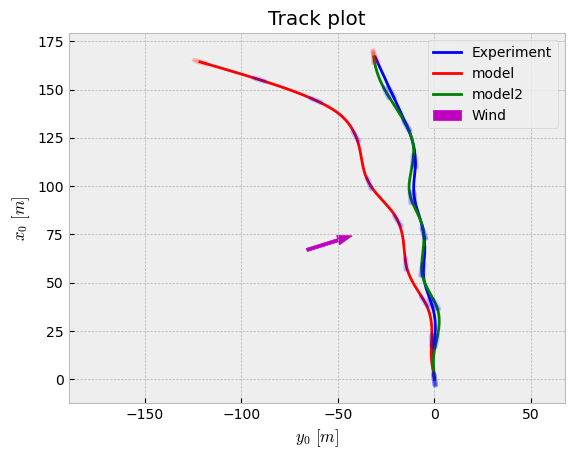

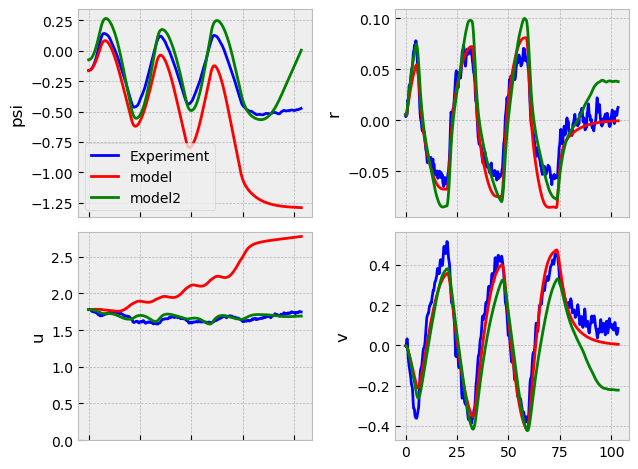

In [116]:

dataframes = {
'Experiment':mean(data.rolling(2)),
#'Experiment':data,
'model' : result.result,
'model2' : result2.result
    
}
time_window=[0, np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
             time_window=time_window, N=10);
ax.legend(loc='upper right')

plot(dataframes, keys=['u','v','r','psi'], time_window=time_window);